In [22]:
import logging
import os
import sys
import tempfile
from glob import glob

import torch
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import monai
from monai.data import ArrayDataset, create_test_image_2d, decollate_batch
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.transforms import (
    Activations,
    AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    RandRotate90,
    RandSpatialCrop,
    ScaleIntensity,
    EnsureType,
)
from PIL import Image, ImageDraw

from monai.visualize import plot_2d_or_3d_image
import numpy as np
import matplotlib.pyplot as plt

from typing import Optional, Tuple
from monai.transforms.utils import rescale_array
from os import mkdir
from os.path import isdir



In [73]:
print(monai.__version__)


OUTPUT = ROOT_EXP + 'results/'
EXPERIMENT = 'synthetic/' # 'synthetic', 'ISLES', 'BRATS'
ROOT_EXP   = '/home/diffusion/Dropbox/Documents/CHUV/ASAP/FederatedLearning/fedem/'
ROOT_DATA  = 'data/'+EXPERIMENT

if(not isdir(OUTPUT)):
    mkdir(OUTPUT)
    
# models folder 

if( not isdir(ROOT_EXP+"/models/"+EXPERIMENT)):
    mkdir(ROOT_EXP+"/models/"+EXPERIMENT)
    
#At insel: /home/sebastian/experiments/fedem/data/'

0.8.0


In [74]:
monai.config.print_config()
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

MONAI version: 0.8.0
Numpy version: 1.20.3
Pytorch version: 1.10.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 714d00dffe6653e21260160666c4c201ab66511b

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: 0.18.1
Pillow version: 8.3.1
Tensorboard version: 2.7.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.11.1
tqdm version: 4.62.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.8.0
pandas version: 1.3.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.11.3
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [75]:
train_dir = ROOT_DATA + 'train/'
val_dir   = ROOT_DATA + 'val/'
test_dir  = ROOT_DATA + 'test/'

In [76]:
imagepaths_train  = sorted(glob(os.path.join(train_dir, "*img*.png")))
segmpaths_train   = sorted(glob(os.path.join(train_dir, "*seg*.png")))
print(len(imagepaths_train),len(segmpaths_train))

imagepaths_val  = sorted(glob(os.path.join(val_dir, "*img*.png")))
segmpaths_val   = sorted(glob(os.path.join(val_dir, "*seg*.png")))
print(len(imagepaths_val),len(segmpaths_val))

imagepaths_test  = sorted(glob(os.path.join(test_dir, "*img*.png")))
segmpaths_test   = sorted(glob(os.path.join(test_dir, "*seg*.png")))
print(len(imagepaths_test),len(segmpaths_test))

90 90
10 10
20 20


In [77]:
# define transforms for image and segmentation
train_imtrans = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        ScaleIntensity(),
        RandSpatialCrop((96, 96), random_size=False),
        RandRotate90(prob=0.5, spatial_axes=(0, 1)),
        EnsureType(),
    ]
)
train_segtrans = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        ScaleIntensity(),
        RandSpatialCrop((96, 96), random_size=False),
        RandRotate90(prob=0.5, spatial_axes=(0, 1)),
        EnsureType(),
    ]
)

In [78]:
val_imtrans  = Compose([LoadImage(image_only=True), AddChannel(), ScaleIntensity(), EnsureType()])
val_segtrans = Compose([LoadImage(image_only=True), AddChannel(), ScaleIntensity(), EnsureType()])

# define array dataset, data loader
check_ds     =    ArrayDataset(imagepaths_train, train_imtrans, segmpaths_train, train_segtrans)
check_loader = DataLoader(check_ds, batch_size=10, num_workers=2, pin_memory=torch.cuda.is_available())
im, seg      =  monai.utils.misc.first(check_loader)
print(im.shape, seg.shape)

torch.Size([10, 1, 96, 96]) torch.Size([10, 1, 96, 96])


In [79]:
# create a training data loader
train_ds = ArrayDataset(imagepaths_train, train_imtrans, segmpaths_train, train_segtrans)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=8, pin_memory=torch.cuda.is_available()
                         )
# create a validation data loader
val_ds = ArrayDataset(imagepaths_val, val_imtrans, segmpaths_val, val_segtrans)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4, pin_memory=torch.cuda.is_available())

#create the test data loader
test_ds = ArrayDataset(imagepaths_test, val_imtrans, segmpaths_test, val_segtrans)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=torch.cuda.is_available())

dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
dice_metric_test = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)


post_trans = Compose([EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold=0.5)])
# create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


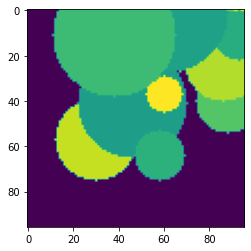

In [80]:
plt.imshow(train_ds[0][0][0].cpu())

In [114]:
best_val_performances = []
test_performances = []
file_performances_test = open( OUTPUT+ 'performances_dice_'+EXPERIMENT.split('/')[0]+'.txt','w')
epocs = 50
runs = 10
for run_num in range(runs):
    print(f"Training for run {run_num}")
    model = monai.networks.nets.UNet(
        spatial_dims=2,
        in_channels=1,
        out_channels=1,
        channels=(16, 32, 64),
        strides=(2, 2, 2),
        num_res_units=2,
    ).to(device)

    loss_function = monai.losses.DiceLoss(sigmoid=True)
    optimizer     = torch.optim.Adam(model.parameters(), 1e-3)

    # start a typical PyTorch training
    val_interval = 2
    best_metric  = -1
    best_metric_epoch = -1
    
    epoch_loss_values  = list()
    metric_values      = list()
    metric_values_test = list()
    writer = SummaryWriter()
    
    for epoch in range(epocs):
        
        print("-" * 10)
        print(f"epoch {epoch + 1}/{10}")
        model.train()
        epoch_loss = 0
        step = 0
        
        for batch_data in train_loader:
            step += 1
            inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            epoch_len   = len(train_ds) // train_loader.batch_size
            
            print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
            writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
            
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
        if (epoch + 1) % val_interval == 0:
            model.eval()
            
            with torch.no_grad():
                val_images  = None
                val_labels  = None
                val_outputs = None
                
                for val_data in val_loader:
                    val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                    roi_size = (96, 96)
                    sw_batch_size = 4
                    val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
                    val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                    # compute metric for current iteration
                    #print("========")
                    #print(val_outputs[0].shape,val_labels[0].shape)
                    dice_metric(y_pred=val_outputs, y=val_labels)
                    #print("========")

                # aggregate the final mean dice result
                metric = dice_metric.aggregate().item()
                # reset the status for next validation round
                dice_metric.reset()
                metric_values.append(metric)
                
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    
                    torch.save(model.state_dict(),ROOT_EXP+"/models/"+EXPERIMENT+"run_" +str(run_num)+"_best_metric_model_segmentation2d_array.pth")
                   
                print("saved new best metric model")
                print(
                    "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
                        epoch + 1, metric, best_metric, best_metric_epoch
                    )
                )
                writer.add_scalar("val_mean_dice", metric, epoch + 1)
                # plot the last model output as GIF image in TensorBoard with the corresponding image and label
                plot_2d_or_3d_image(val_images, epoch + 1, writer, index=0, tag="image")
                plot_2d_or_3d_image(val_labels, epoch + 1, writer, index=0, tag="label")
                plot_2d_or_3d_image(val_outputs, epoch + 1, writer, index=0, tag="output")
    
    best_val_performances.append(best_metric)
    
    plt.figure("train", (12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Epoch Average Loss")
    x = [i + 1 for i in range(len(epoch_loss_values))]
    y = epoch_loss_values
    plt.xlabel("epoch")
    plt.plot(x, y, color="red")
    plt.ylim([0.,0.5])
    plt.subplot(1, 2, 2)
    plt.title("Val Mean Dice")
    x = [val_interval * (i + 1) for i in range(len(metric_values))]
    y = metric_values
    plt.xlabel("epoch")
    plt.plot(x, y, color="green")
    plt.ylim([0.5,1])
    plt.savefig(OUTPUT+ f'trainin_dice_run_{run_num}_'+EXPERIMENT.split('/')[0]+'.jpg')
    plt.show()

    
    
    #Evaluation in the test partition
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        roi_size = (96, 96)
        sw_batch_size = 4
        test_outputs = sliding_window_inference(test_images, roi_size, sw_batch_size, model)
        test_outputs = [post_trans(i) for i in decollate_batch(test_outputs)]
        dice_metric_test(y_pred=test_outputs, y=test_labels)
    metric_test = dice_metric_test.aggregate().item()
    
    dice_metric_test.reset()
    test_performances.append(metric_test)
    print("Dice in Test partition for run " + str(run_num) + str(metric_test))
    file_performances_test.write(str(metric_test)+'\n')
    
    
    
    
file_performances_test.close()

Training for run 0
----------
epoch 1/10
1/22, train_loss: 0.3985
2/22, train_loss: 0.3592
3/22, train_loss: 0.4318
4/22, train_loss: 0.4186
5/22, train_loss: 0.3810
6/22, train_loss: 0.3421
7/22, train_loss: 0.4134
8/22, train_loss: 0.4046
9/22, train_loss: 0.3924
10/22, train_loss: 0.3602
11/22, train_loss: 0.3717
12/22, train_loss: 0.3513
13/22, train_loss: 0.3719
14/22, train_loss: 0.3648
15/22, train_loss: 0.3968
16/22, train_loss: 0.3580
17/22, train_loss: 0.3729
18/22, train_loss: 0.4743
19/22, train_loss: 0.3697
20/22, train_loss: 0.3694
21/22, train_loss: 0.3596
22/22, train_loss: 0.4604
23/22, train_loss: 0.4083
epoch 1 average loss: 0.3883
----------
epoch 2/10
1/22, train_loss: 0.4054
2/22, train_loss: 0.3451
3/22, train_loss: 0.3581
4/22, train_loss: 0.3091
5/22, train_loss: 0.3600
6/22, train_loss: 0.3472
7/22, train_loss: 0.4708
8/22, train_loss: 0.3222
9/22, train_loss: 0.3569
10/22, train_loss: 0.4152
11/22, train_loss: 0.3222
12/22, train_loss: 0.3524
13/22, train_los

saved new best metric model
current epoch: 12 current mean dice: 0.9825 best mean dice: 0.9825 at epoch 12
----------
epoch 13/10
1/22, train_loss: 0.1588
2/22, train_loss: 0.1194
3/22, train_loss: 0.1943
4/22, train_loss: 0.1212
5/22, train_loss: 0.1213
6/22, train_loss: 0.1630
7/22, train_loss: 0.1731
8/22, train_loss: 0.1903
9/22, train_loss: 0.1243
10/22, train_loss: 0.0994
11/22, train_loss: 0.1059
12/22, train_loss: 0.0981
13/22, train_loss: 0.2259
14/22, train_loss: 0.2035
15/22, train_loss: 0.1382
16/22, train_loss: 0.1561
17/22, train_loss: 0.1026
18/22, train_loss: 0.1434
19/22, train_loss: 0.1322
20/22, train_loss: 0.1001
21/22, train_loss: 0.1050
22/22, train_loss: 0.1361
23/22, train_loss: 0.1493
epoch 13 average loss: 0.1418
----------
epoch 14/10
1/22, train_loss: 0.1605
2/22, train_loss: 0.1044
3/22, train_loss: 0.1834
4/22, train_loss: 0.1051
5/22, train_loss: 0.1394
6/22, train_loss: 0.1268
7/22, train_loss: 0.2681
8/22, train_loss: 0.0938
9/22, train_loss: 0.1313
10/

epoch 24 average loss: 0.0575
saved new best metric model
current epoch: 24 current mean dice: 0.9966 best mean dice: 0.9966 at epoch 24
----------
epoch 25/10
1/22, train_loss: 0.0367
2/22, train_loss: 0.0406
3/22, train_loss: 0.0624
4/22, train_loss: 0.0371
5/22, train_loss: 0.0520
6/22, train_loss: 0.0640
7/22, train_loss: 0.0527
8/22, train_loss: 0.0312
9/22, train_loss: 0.0444
10/22, train_loss: 0.0441
11/22, train_loss: 0.0937
12/22, train_loss: 0.0386
13/22, train_loss: 0.0954
14/22, train_loss: 0.0658
15/22, train_loss: 0.0624
16/22, train_loss: 0.0705
17/22, train_loss: 0.0449
18/22, train_loss: 0.0473
19/22, train_loss: 0.0605
20/22, train_loss: 0.0640
21/22, train_loss: 0.0360
22/22, train_loss: 0.0377
23/22, train_loss: 0.0354
epoch 25 average loss: 0.0529
----------
epoch 26/10
1/22, train_loss: 0.0499
2/22, train_loss: 0.0498
3/22, train_loss: 0.0363
4/22, train_loss: 0.0439
5/22, train_loss: 0.0574
6/22, train_loss: 0.0713
7/22, train_loss: 0.0449
8/22, train_loss: 0.035

Exception ignored in: <function _releaseLock at 0x7fcbd3f97430>
Traceback (most recent call last):
  File "/home/diffusion/anaconda3/lib/python3.8/logging/__init__.py", line 223, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


RuntimeError: DataLoader worker (pid(s) 954033, 954034, 954035, 954036, 954037, 954038) exited unexpectedly

In [101]:
metric_values

[0.953996479511261,
 0.9896892309188843,
 0.9908259510993958,
 0.9917038679122925,
 0.9910589456558228,
 0.9922393560409546,
 0.9937246441841125,
 0.996110737323761,
 0.9956599473953247,
 0.9980174899101257,
 0.9973326921463013,
 0.9991334676742554,
 0.9991368055343628,
 0.9993363618850708,
 0.9995366930961609,
 0.9995816946029663,
 0.9994035959243774,
 0.9997049570083618,
 0.9995759129524231,
 0.9995445013046265,
 0.9996663928031921,
 0.999783992767334,
 0.9997831583023071,
 0.9998233914375305,
 0.9997817873954773]

In [112]:
test_performances

[0.9998589754104614,
 0.9998695254325867,
 0.9997358322143555,
 0.9998323321342468,
 0.9997493624687195,
 0.9997042417526245,
 0.9998466372489929,
 0.9998442530632019,
 0.9998934864997864,
 0.9998286366462708]

In [113]:
best_val_performances

[0.9996797442436218,
 0.9997550845146179,
 0.9994009733200073,
 0.9996358752250671,
 0.999518096446991,
 0.9995082020759583,
 0.9998092651367188,
 0.9996762275695801,
 0.9997539520263672,
 0.9996479153633118]

In [ ]:
### print(val_outputs[0].shape, val_labels.shape)

In [104]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()

train completed, best_metric: 0.9998 at epoch: 48


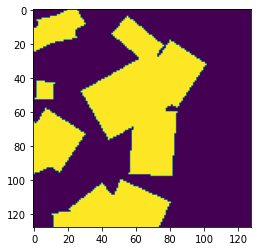

In [105]:
plt.imshow(val_outputs[0][0].cpu().numpy())

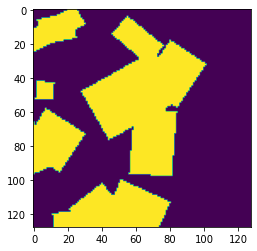

In [106]:
plt.imshow(val_labels[0][0].cpu().numpy())

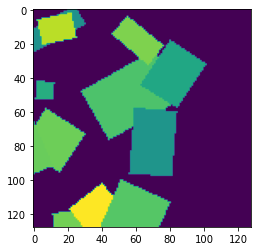

In [107]:
plt.imshow(val_images[0][0].cpu().numpy())